# DeepAR
## Why We Chose DeepAR for Bitcoin Fee Forecasting

Our exploratory data analysis revealed several key characteristics in the Bitcoin fee time series that informed our model selection:

### Key Observations from EDA

- **Strong temporal patterns**: The series exhibits clear intraday and multi-day cycles.
- **Volatility and sharp spikes**: Transaction fees fluctuate unpredictably with sudden, high-magnitude surges.
- **Multivariate dependencies**: Fee behavior is influenced by multiple covariates such as mempool congestion, difficulty adjustment, and market signals.
- **Lagged effects**: Both the target and covariates show meaningful dependencies on past values.

### Why DeepAR is a Good Fit

- **Probabilistic autoregressive modeling**: DeepAR models future values as a distribution conditioned on historical data, making it suitable for capturing uncertainty and variability.
- **Sequence-to-sequence RNN structure**: It naturally captures temporal dependencies and lagged effects, especially for high-frequency financial time series.
- **Handles multiple related time series**: DeepAR can leverage patterns across different fee types (e.g., fastestFee, hourFee, economyFee) to improve prediction accuracy.
- **Distributional output**: The model supports flexible likelihoods (e.g., Gaussian, LogNormal), making it adaptable to the right-skewed nature of fee data.
- **Scalable and generalizable**: Suitable for long training histories and aligned prediction horizons across series.

Given these factors, DeepAR offers a strong balance of flexibility, probabilistic forecasting, and temporal modeling capacity for our transaction fee prediction task.
> All commented code should be refer to `root/scripts/deear.py` and should be ran following the instruction in the Readme.md

## 1. Data Import, Transformation, and Preparation

This section prepares the dataset for training a DeepAR model. DeepAR requires a long-format time series with consistent time steps, encoded time features, and normalized inputs. We perform preprocessing, transformation, and scaling to ensure the model receives structured, normalized, and correctly segmented input.

In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, MultiHorizonMetric
from pytorch_forecasting.data import GroupNormalizer
import pytorch_forecasting as ptf

import os
import sys
from pathlib import Path

# Add ../src to the Python module search path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))



/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Import raw Bitcoin mempool and fee data, clean, and resample it
from preprocess_raw_parquet import preprocess_raw_parquet
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")  # Clean and structure raw input from .parquet
df = df.iloc[:-96]
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Transform the cleaned data for DeepAR modeling
from transform_fee_data_dl import transform_fee_data_dl
df = transform_fee_data_dl(df)  # Adds time encodings, reshapes to long format, assigns time_idx

df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,7971.000000,4.809659e+07,...,0.0,0,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,9943.333333,4.946978e+07,...,0.0,1,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,2.832769e-16
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,8189.333333,4.936482e+07,...,0.0,2,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,5.665539e-16,-1.000000e+00
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,8874.666667,5.061585e+07,...,0.0,3,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,11247.333333,5.158261e+07,...,0.0,4,0.707107,0.707107,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00


In [4]:
FREQ = "15min"  # Frequency of the time series: one data point every 15 minutes.
ENC_LEN = 672  # Length of the encoder input (7 days): 672 × 15min = 7 days.
PRED_STEPS = 96  # Forecasting horizon (1 day): 96 × 15min = 24 hours.

BATCH_SIZE = 128  # Number of samples per batch for model training.
NUM_WORKERS = 4  # Number of CPU threads used for data loading.


In [5]:
from split_series import split_series
from scale_series import scale_series
from add_lag_features import add_lag_features
exclude_cols = [
    "timestamp",
    "series_id",
    "target",
    "time_idx",
    "hour_sin",
    "hour_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_sin",
    "month_cos",
    "minute_sin",
    "minute_cos",
]

for col in df.columns:
    if col not in exclude_cols and not col.startswith("mempool_fee_histogram_bin"):
        df = add_lag_features(df, col, 96)

df_train, df_valid = split_series(df, PRED_STEPS)
df_train, df_valid, scaler = scale_series(df_train, df_valid)


### **Why this step is important**:  
- DeepAR assumes evenly spaced sequences and benefits from standardized inputs.  
- Proper splitting ensures that validation/test sets simulate real-world future forecasting.  
- Transformation aligns data with DeepAR's encoder-decoder format, enabling autoregressive learning.  
- Normalization improves training stability and convergence.
---

## 2. Create DeepAR-Compatible TimeSeriesDataSet

In this step, we construct `TimeSeriesDataSet` objects that prepare our training and validation data in the format required by DeepAR. This includes specifying time indices, group identifiers, covariates, and normalizing the target variable. Proper setup ensures correct slicing into encoder/decoder windows and enables autoregressive training with static and dynamic features.


In [6]:
# last_idx = df_valid.time_idx.max()  
# training_cutoff = last_idx - PRED_STEPS
# real_covs = [
#     c for c in df_train.columns if c.startswith(("mempool", "difficulty", "price"))
# ]

# # Lagged features are considered "known" at prediction time
# known_lagged_covs = [
#     c
#     for c in df_train.columns
#     if (
#         "_lag_" in c
#         and (
#             c.startswith("mempool_")
#             or c.startswith("difficulty_")
#             or c.startswith("price_")
#             or c.startswith("target")
#         )
#     )
# ]

# # Unlagged real-valued features are "unknown" at prediction time
# unknown_real_covs = [c for c in real_covs if c not in known_lagged_covs]

# # Construct the training TimeSeriesDataSet for DeepAR
# training = TimeSeriesDataSet(
#     df_train,
#     time_idx="time_idx",  # Required time index
#     target="target",  # Target variable (e.g., recommended_fee_fastest)
#     group_ids=["series_id"],  # Unique series per fee type
#     min_encoder_length=ENC_LEN // 2,  # For variable-length sequences
#     max_encoder_length=ENC_LEN,  # Full encoder context: 7 days
#     max_prediction_length=PRED_STEPS,  # Forecast 1 day ahead (96 steps)
#     # Static (non-changing) categorical features, such as series ID
#     static_categoricals=["series_id"],
#     # Known inputs at forecast time — calendar and lagged values
#     time_varying_known_reals=[
#         "time_idx",
#         "hour_sin",
#         "hour_cos",
#         "day_of_week_sin",
#         "day_of_week_cos",
#         "month_sin",
#         "month_cos",
#         "minute_sin",
#         "minute_cos",
#     ]
#     + known_lagged_covs,
#     # Unknown inputs
#     time_varying_unknown_reals=["target"],
#     # Normalize target independently per time series
#     target_normalizer=GroupNormalizer(groups=["series_id"]),
#     # Add helper features for better learning
#     add_relative_time_idx=True,  # Adds relative time indices (0...N)
#     add_target_scales=True,  # Adds per-series target mean and std
#     add_encoder_length=True,  # Adds actual encoder length (for padding)
# )


# # Create validation TimeSeriesDataSet using same configuration
# validation = TimeSeriesDataSet.from_dataset(
#     training,  # Inherit all preprocessing configs from training set
#     df_valid,  # Apply to validation DataFrame
#     min_prediction_idx=training_cutoff + 1,  # Ensures predictions begin after training
# )

### **Why this step is important**:  
- DeepAR needs structured input with consistent history and forecast windows.  
- Group normalization stabilizes learning across heterogeneous series.  
- Using `from_dataset` ensures validation data is aligned identically with training preprocessing, avoiding leakage and inconsistency.  
- Encodes time context (sin/cos) to help the model capture periodic patterns like hourly/daily cycles.
---

## 3. Create DataLoaders for DeepAR Training and Validation

We now convert the `TimeSeriesDataSet` objects into PyTorch-compatible DataLoaders. This enables efficient batching and iteration during training and validation. Time series order must be preserved (no shuffling), and we use larger batch sizes for validation to speed up evaluation.


In [7]:
# # Set number of CPU workers for data loading (max 4 or available cores)
# NUM_WORKERS = min(4, os.cpu_count())

# # Create training dataloader
# train_dl = training.to_dataloader(
#     train=True,
#     batch_size=BATCH_SIZE,
#     shuffle=False,  # Time order must be preserved — no shuffling
#     num_workers=NUM_WORKERS,
#     persistent_workers=False,  # Set to False for compatibility across OSes
# )

# # Create validation dataloader
# val_dl = validation.to_dataloader(
#     train=False,
#     batch_size=BATCH_SIZE * 10,  # Larger batch size to speed up inference
#     shuffle=False,  # Again, preserve temporal order
#     num_workers=NUM_WORKERS,
#     persistent_workers=False,
# )


### **Why this step is important**:  
- Ensures efficient loading of sequence data into the DeepAR model for both training and evaluation.  
- Maintains time dependency by disabling shuffling — crucial for autoregressive models.  
- Larger validation batches reduce runtime since no gradients are computed.
---

## 4. Initialize DeepAR Model and Tune Learning Rate

In this section, we initialize the DeepAR model with key architectural choices and perform learning rate tuning using PyTorch Lightning’s `Tuner`

In [8]:
# # Set up the trainer (CPU backend; gradient clipping to avoid exploding gradients)
# trainer = pl.Trainer(accelerator="cpu", devices=1, gradient_clip_val=0.1)

# # Initialize DeepAR model
# net = DeepAR.from_dataset(
#     training,
#     learning_rate=3e-2,  # Placeholder, will be tuned
#     hidden_size=30,  # RNN hidden size
#     rnn_layers=2,  # Number of RNN layers
#     loss=MultivariateNormalDistributionLoss(),  # Distribution-based loss for probabilistic forecasting
#     optimizer="Adam",  # Optimizer choice
# )


In [9]:
# # Use learning rate finder to optimize training speed and stability
# res = Tuner(trainer).lr_find(
#     net,
#     train_dataloaders=train_dl,
#     val_dataloaders=val_dl,
#     min_lr=1e-5,
#     max_lr=1e0,
#     early_stop_threshold=100,  # Stop early if loss spikes
# )
# # Print and apply the suggested learning rate
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()
# net.hparams.learning_rate = res.suggestion()


### **Why this step is important**:  
- Choosing the correct learning rate is critical to DeepAR’s convergence.  
- Learning rate tuning prevents instability (too high) or slow training (too low).  
- `MultivariateNormalDistributionLoss` supports probabilistic outputs, allowing the model to estimate uncertainty, which is useful for forecasting volatile transaction fees.
---

## 5. Train DeepAR Model with Early Stopping

This section configures the training process using PyTorch Lightning. We apply early stopping to halt training when validation loss plateaus, preventing overfitting and saving compute resources. We then train the DeepAR model using the tuned configuration and prepared dataloaders.


In [10]:
# # Set early stopping to monitor validation loss and stop if no improvement
# early_stop_callback = EarlyStopping(
#     monitor="val_loss",  # Watch validation loss
#     min_delta=1e-4,  # Minimum improvement threshold
#     patience=10,  # Stop after 10 epochs without improvement
#     verbose=False,
#     mode="min",  # We want to minimize the loss
# )
# # Configure PyTorch Lightning trainer
# trainer = pl.Trainer(
#     max_epochs=30,  # Maximum number of training epochs
#     accelerator="cpu",  # Run on CPU
#     enable_model_summary=True,  # Print model architecture
#     gradient_clip_val=0.1,  # Prevent exploding gradients
#     callbacks=[early_stop_callback],
#     enable_checkpointing=True,  # Save best model
# )
# # Initialize DeepAR model
# net = DeepAR.from_dataset(
#     training,
#     learning_rate=0.0003,  # Learning rate tuned via lr_finder
#     hidden_size=30,  # RNN hidden units, recommended by pytorch tutorial
#     rnn_layers=2,  # RNN depth, recommended by pytorch tutorial
#     loss=MultivariateNormalDistributionLoss(
#         rank=30
#     ),  # Probabilistic loss with covariance structure
#     optimizer="Adam",
# )
# # Train the model
# # trainer.fit(
# #     net,
# #     train_dataloaders=train_dl,
# #     val_dataloaders=val_dl,
# # )

### **Why this step is important**:  
- Training with early stopping helps avoid overfitting and wasted computation.  
- The chosen loss function allows DeepAR to model uncertainty, crucial for forecasting Bitcoin fees.  
- Proper training orchestration ensures reproducibility and model checkpointing for later evaluation.
---

## 6. Load Best Model, Generate Predictions, and Evaluate Forecasts

After training, we load the best DeepAR model (based on validation loss), run multi-sample predictions, and evaluate its performance using custom metrics. We compute MAE, RMSE, MAPE, and a custom loss that combines MAE and standard deviation penalty to account for both accuracy and forecast uncertainty.

In [11]:
# Path to the saved DeepAR model (full model saved with torch.save)
best_model_path = "../results/models/best_deepar_model_v5.ckpt"
# best_model_path = "../results/models/best-deepar-full.ckpt" # Or use the model you train
model = DeepAR.load_from_checkpoint(best_model_path, map_location="cpu")

# Set to eval mode
_ = model.eval()

/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [12]:
# Set seed and run raw prediction with 100 samples (for distributional output)
pl.seed_everything(42)
raw_predictions = model.predict(
    df_valid,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu")
)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


In [13]:
# Extract true values for final prediction window
df_true = df_valid[
    lambda x: (x.time_idx > x.time_idx.max() - PRED_STEPS) & (x.time_idx <= x.time_idx.max())
]
df_true.tail()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,difficulty_adjustment_difficultyChange_lag_96,difficulty_adjustment_remainingBlocks_lag_96,difficulty_adjustment_remainingTime_lag_96,difficulty_adjustment_previousTime_lag_96,difficulty_adjustment_nextRetargetHeight_lag_96,difficulty_adjustment_timeAvg_lag_96,difficulty_adjustment_adjustedTimeAvg_lag_96,difficulty_adjustment_timeOffset_lag_96,difficulty_adjustment_expectedBlocks_lag_96,price_USD_lag_96
32515,2025-05-11 18:45:00,recommended_fee_minimumFee,1.0,-2.698177,-3.350181,-1.466282,-0.882059,-0.719122,-1.141006,-1.092308,...,0.980534,-0.100045,-0.167651,1.727165,1.69503,-0.649359,-0.964529,0.0,0.009635,2.818245
32516,2025-05-11 19:00:00,recommended_fee_minimumFee,1.0,-3.720925,-4.950532,-1.920068,-1.100689,-0.911363,-1.190222,-1.111072,...,0.967588,-0.101755,-0.168423,1.727165,1.69503,-0.643119,-0.952982,0.0,0.012205,2.817779
32517,2025-05-11 19:15:00,recommended_fee_minimumFee,1.0,-0.389310,-0.245134,0.170356,-0.370534,-0.215084,-0.912175,-1.040731,...,0.969391,-0.104605,-0.171316,1.727165,1.69503,-0.644003,-0.954618,0.0,0.014774,2.811261
32518,2025-05-11 19:30:00,recommended_fee_minimumFee,1.0,-0.021092,0.316194,0.879805,0.411153,0.097310,-0.652602,-0.974523,...,0.949169,-0.105745,-0.171036,1.727165,1.69503,-0.634227,-0.936529,0.0,0.017343,2.831281
32519,2025-05-11 19:45:00,recommended_fee_minimumFee,1.0,-0.090955,0.316373,0.940942,0.396153,0.165572,-0.545078,-0.942984,...,0.950981,-0.108596,-0.173934,1.727165,1.69503,-0.635124,-0.938189,0.0,0.019913,2.830059


In [14]:
# Post-process prediction tensor → median forecast
pred_np = (
    raw_predictions.output.prediction.detach().cpu().numpy()
)  # Shape: (samples, series, time)
y_pred = np.median(pred_np, axis=-1).flatten()  # Median across samples
time_idx = raw_predictions.x["decoder_time_idx"].detach().cpu().numpy().flatten()

# Merge predictions with metadata and ground truth
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=time_idx,
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred=y_pred,
    )
)

df_eval.head()


,timestamp,time_idx,series_id,y_true,y_pred
6408,2025-05-10 20:00:00,6408,recommended_fee_economyFee,2.0,1.437433
6409,2025-05-10 20:15:00,6409,recommended_fee_economyFee,2.0,1.582983
6410,2025-05-10 20:30:00,6410,recommended_fee_economyFee,2.0,1.558577
6411,2025-05-10 20:45:00,6411,recommended_fee_economyFee,2.0,1.554276
6412,2025-05-10 21:00:00,6412,recommended_fee_economyFee,2.0,1.574377


In [15]:
from save_csv_data import save_csv_data  # Adjust if defined locally

# Filter rows where series_id is "recommended_fee_fastestFee"
df_filtered = df_eval[df_eval["series_id"] == "recommended_fee_fastestFee"]

# Define output path
output_path = "../results/tables/deepar_results.csv"  # Change as needed

# Save using the utility function
save_csv_data(df_filtered, output_path, index=False)

In [16]:
from mae_with_std_penalty_np import mae_with_std_penalty_np
# Compute evaluation metrics per series
metrics_per_sid = (
    df_eval.groupby("series_id")
    .apply(
        lambda g: pd.Series(
            {
                "MAE": np.abs(g.y_pred - g.y_true).mean(), 
                "RMSE": np.sqrt(((g.y_pred - g.y_true) ** 2).mean()),
                "MAPE": (np.abs((g.y_pred - g.y_true) / g.y_true).mean()),
                "Custom Loss (MAE+STD+Dev)": mae_with_std_penalty_np(
                    g.y_pred.values, g.y_true.values,
                    std_weight=1.0,
                    de_weight=1.0,
                    clip_weight_std=10.0,
                    clip_weight_dev=10.0,
                )
                
            }
        )
    )
    .reset_index()
    .sort_values("Custom Loss (MAE+STD+Dev)")  # Sort by custom objective
)
metrics_per_sid

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_28071/1657107472.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,series_id,MAE,RMSE,MAPE,Custom Loss (MAE+STD+Dev)
4,recommended_fee_minimumFee,0.000038,0.000046,0.000038,0.000112
0,recommended_fee_economyFee,0.460244,0.496847,0.373213,1.380732
2,recommended_fee_halfHourFee,0.770656,0.955447,0.529608,2.307244
3,recommended_fee_hourFee,0.781605,0.868438,0.572924,2.344816
1,recommended_fee_fastestFee,0.924080,1.152672,0.510507,2.762892


### **Why this step is important**:  
- Ensures evaluation is based on the best-performing model checkpoint.  
- Median over samples provides robust point forecasts from probabilistic DeepAR output.  
- Custom metric with MAE + STD penalty balances accuracy with stability, rewarding consistent yet sharp forecasts — critical for volatile series like Bitcoin fees.
---

## 7. Visualize Forecasts: Actual vs. Predicted per Series

To qualitatively assess DeepAR’s performance, we visualize the predicted vs. actual transaction fees for multiple series. This helps validate that the model not only fits metrics but also captures spike timing, magnitude, and variance across time.


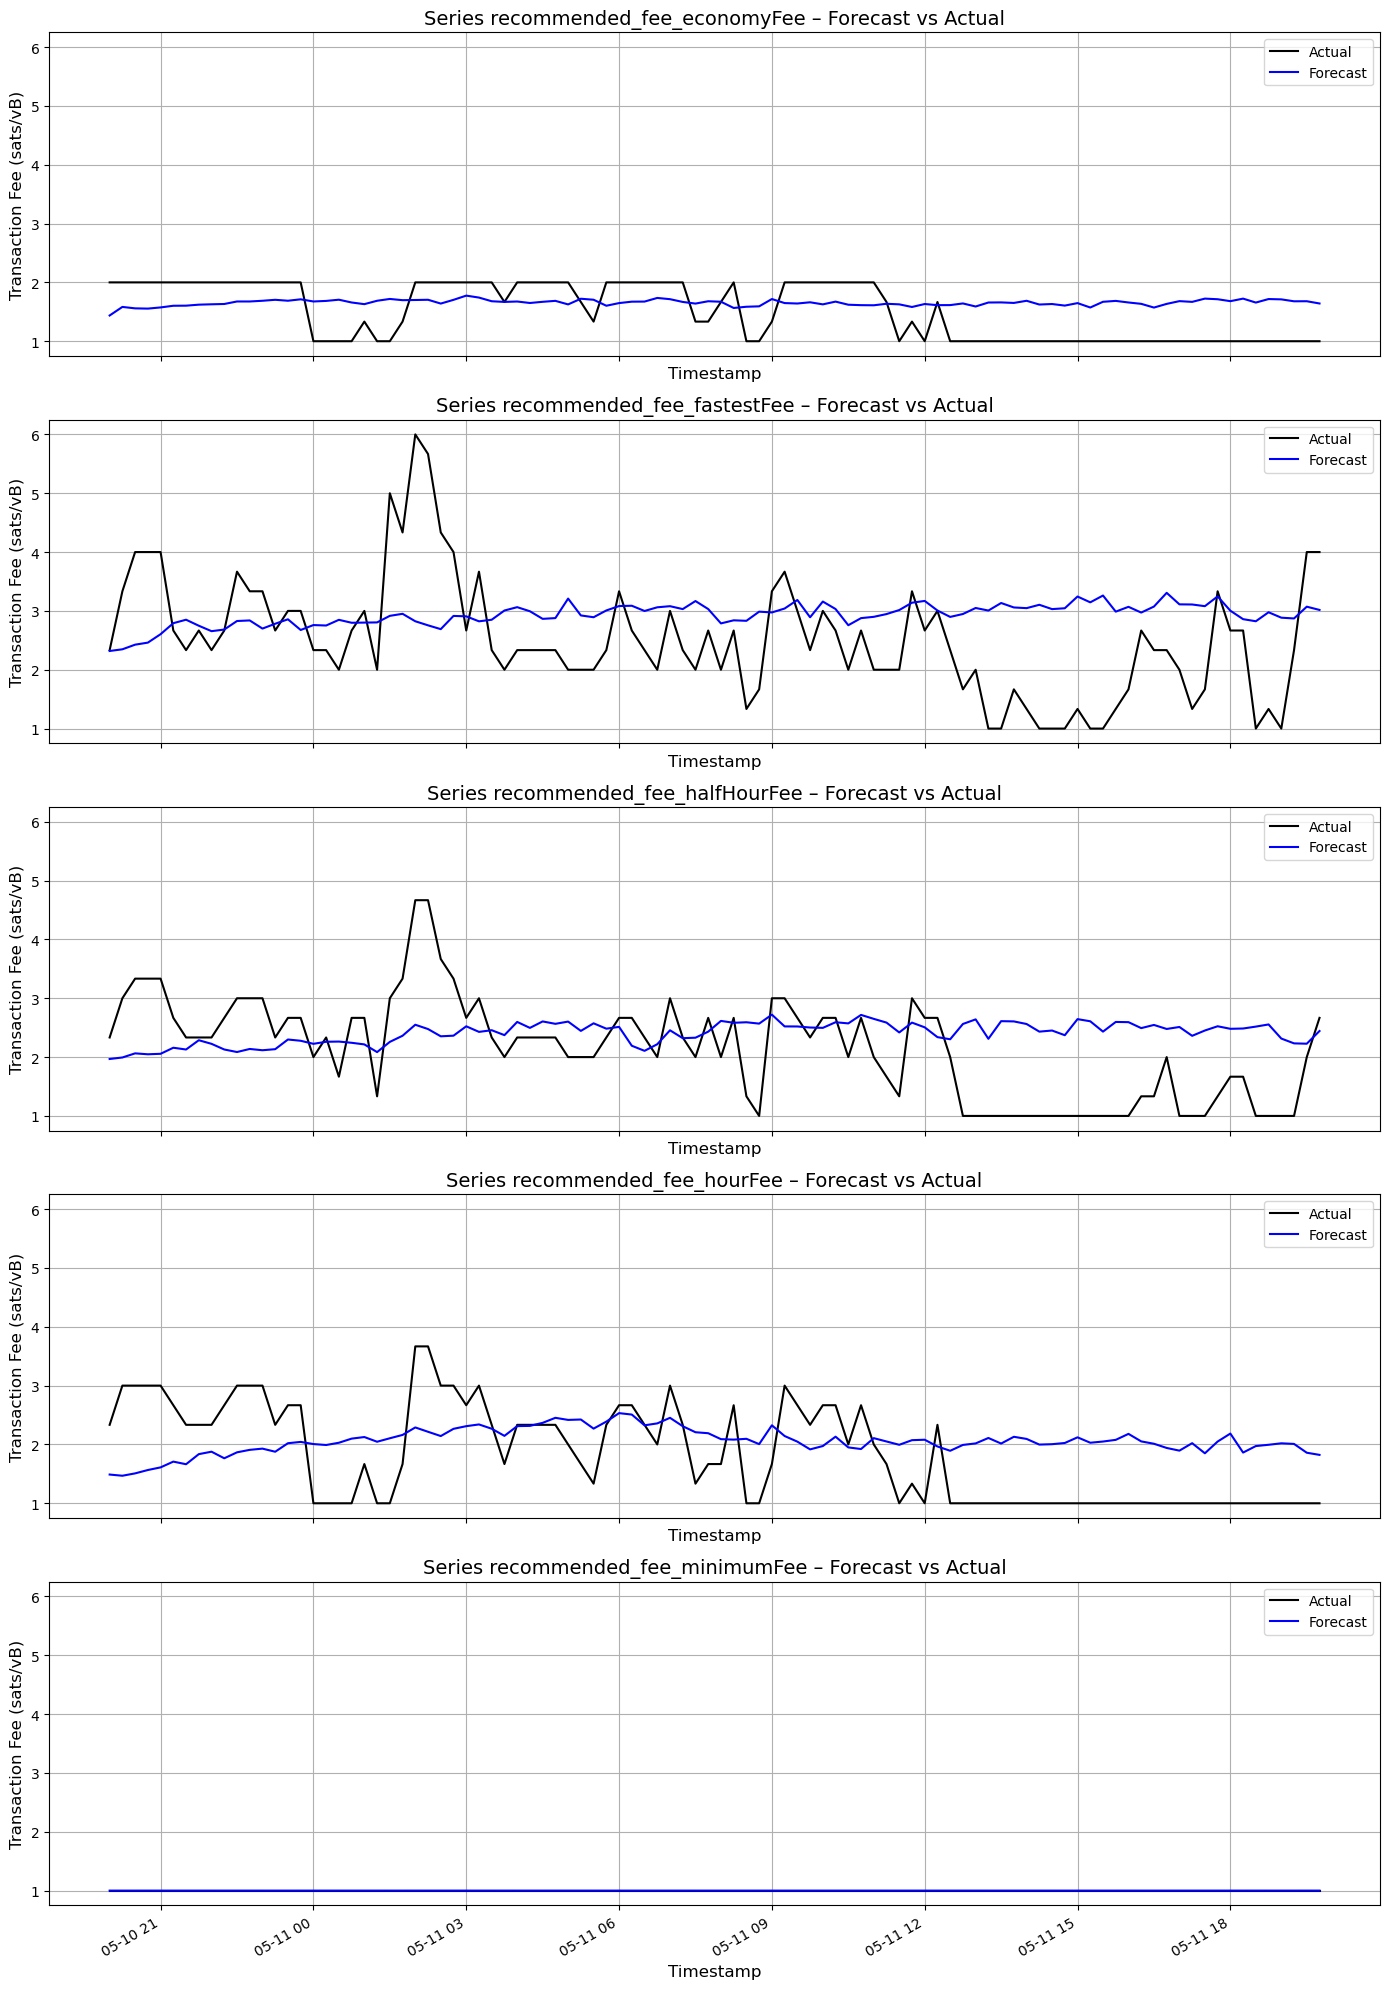

In [17]:
from plot_series import plot_series
fig, axs = plt.subplots(5, 1, figsize=(14, 20), sharex=True, sharey=True)

# Loop over 5 unique series_ids and corresponding axes
for i, sid in enumerate(df_eval.series_id.unique()[:5]):
    plot_series(df_eval, sid, ax=axs[i])  # pass df_eval explicitly

plt.tight_layout()
plt.show()

### **Why this step is important**:  
- Visual checks can reveal issues missed by aggregate metrics, such as lagging predictions, missed spikes, or unstable noise.  
- Ensures model predictions are interpretable and aligned with expected fee dynamics — essential for operational deployment in real-time Bitcoin fee estimation.

## 8. Conclusion: DeepAR for Bitcoin Fee Forecasting

In this notebook, we implemented a full DeepAR pipeline using PyTorch Forecasting to model and forecast Bitcoin transaction fees. The key steps included:

- **Preprocessing** and transforming multivariate time series data into a format compatible with sequence models.
- **Constructing TimeSeriesDataSet** objects with appropriate encoder/decoder lengths, covariates, and normalization.
- **Training the DeepAR model** with early stopping and learning rate tuning to ensure stable convergence.
- **Saving and loading** model checkpoints for reproducibility and deployment.
- **Evaluating performance** using MAE, RMSE, MAPE, and a custom MAE + STD penalty metric to account for both point accuracy and forecast variance.
- **Visualizing forecasts** to verify the model's ability to capture temporal dynamics and volatility in fee spikes.

### Key Takeaways:
- DeepAR is well-suited for forecasting Bitcoin fee series due to its ability to model **temporal dependencies**, **probabilistic uncertainty**, and **cross-series patterns**.
- Proper scaling, series separation (`series_id`), and window slicing (encoder/prediction) are critical to autoregressive models.
- Visualization and custom metrics help ensure that the model captures not just average behavior, but also the volatility that matters in fee-sensitive systems.

This modeling setup can now serve as a robust baseline for more advanced architectures like Transformer-based models (e.g., TFT) or external signal enrichment using price/mempool dynamics. Future improvements may include:
- Exploring adding weight to custom metric.
- Try to think of a better loss function. DeepAR requires a distribution loss.

